# Convolutional Neural Network MNIST

### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

### Transform

In [2]:
# It is known for this dataset but we can also calculate it by looping through the dataset
mean_gray = 0.1307
stddev_gray = 0.3081

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_gray,), (stddev_gray,))
])

### Dataset

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

### Plotting

Label: 4


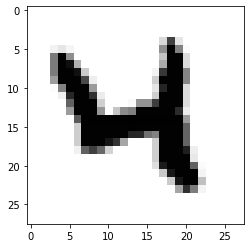

In [4]:
plt.imshow(train_dataset[20][0].numpy().squeeze(), cmap='gray_r')
print('Label:', train_dataset[20][1])

### Data Loader

In [5]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [6]:
class CNNMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)   
        self.conv2 = nn.Conv2d(8, 32, 5, 1, 2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(7*7*32, 600)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(600, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        # Flatten
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

### Model Object

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNNMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training

In [8]:
epochs = 15
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0
    model.train() # Set model to training mode (for dropout and batchnorm)
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        # Calculate loss
        loss = criterion(outputs, labels)
        iter_loss += loss.item()
        iterations += 1
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(100 * correct/len(train_dataset))
    
    correct = 0
    iterations = 0
    iter_loss = 0.0
    model.eval() # Set model to evaluation mode (for dropout and batchnorm)
    for i, (images, labels) in enumerate(test_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        # Calculate loss
        loss = criterion(outputs, labels)
        iter_loss += loss.item()
        iterations += 1
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    
    test_loss.append(iter_loss/iterations)
    test_accuracy.append(100 * correct/len(test_dataset))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_accuracy[-1]:.2f}, Test Loss: {test_loss[-1]:.4f}, Test Acc: {test_accuracy[-1]:.2f}")

Epoch 1/15, Train Loss: 0.1701, Train Acc: 94.64, Test Loss: 0.0469, Test Acc: 98.37
Epoch 2/15, Train Loss: 0.0692, Train Acc: 97.85, Test Loss: 0.0353, Test Acc: 98.82
Epoch 3/15, Train Loss: 0.0518, Train Acc: 98.37, Test Loss: 0.0333, Test Acc: 98.88
Epoch 4/15, Train Loss: 0.0413, Train Acc: 98.65, Test Loss: 0.0259, Test Acc: 99.10
Epoch 5/15, Train Loss: 0.0348, Train Acc: 98.88, Test Loss: 0.0299, Test Acc: 99.07
Epoch 6/15, Train Loss: 0.0312, Train Acc: 99.01, Test Loss: 0.0260, Test Acc: 99.19
Epoch 7/15, Train Loss: 0.0277, Train Acc: 99.11, Test Loss: 0.0283, Test Acc: 99.16
Epoch 8/15, Train Loss: 0.0237, Train Acc: 99.22, Test Loss: 0.0240, Test Acc: 99.28
Epoch 9/15, Train Loss: 0.0200, Train Acc: 99.34, Test Loss: 0.0278, Test Acc: 99.12
Epoch 10/15, Train Loss: 0.0170, Train Acc: 99.43, Test Loss: 0.0258, Test Acc: 99.26
Epoch 11/15, Train Loss: 0.0155, Train Acc: 99.49, Test Loss: 0.0239, Test Acc: 99.24
Epoch 12/15, Train Loss: 0.0146, Train Acc: 99.49, Test Loss: 0

### Plot Result

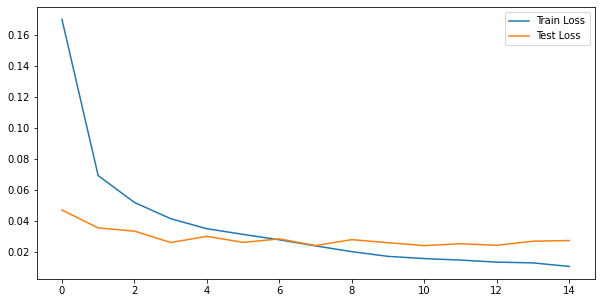

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.show()

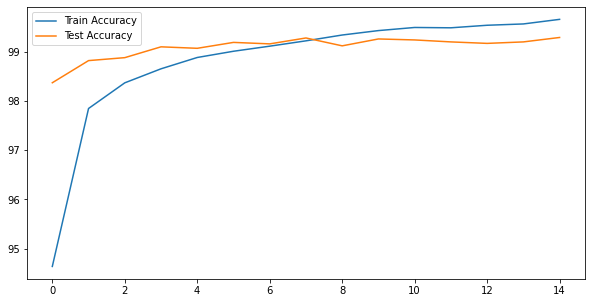

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.legend()
plt.show()

In [11]:
img = test_dataset[30][0].reshape(1, 1, 28, 28).to(device)
label = test_dataset[30][1]
model.eval()
output = model(img)

Actual: 3
Predicted: 3


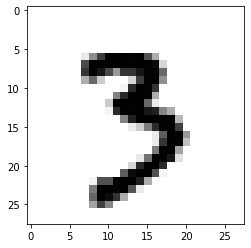

In [12]:
plt.imshow(img.cpu().numpy().squeeze(), cmap='gray_r')
print('Actual:', label)
print('Predicted:', torch.max(output.data, 1)[1].item())

### Classify Own Image

In [13]:
def predict(img_dir, model):
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (28, 28), interpolation=cv2.INTER_AREA)
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    img = Image.fromarray(image)
    img = transform(img)
    img = img.reshape(1, 1, 28, 28).to(device)
    plt.imshow(img.cpu().numpy().squeeze(), cmap='gray_r')
    plt.show()
    model.eval()
    output = model(img)
    print('Predicted:', torch.max(output.data, 1)[1].item())

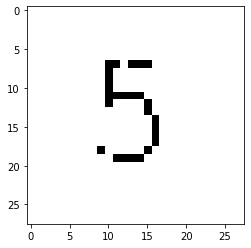

Predicted: 5


In [14]:
predict("./data/mnist_test.png", model=model)